<a href="https://colab.research.google.com/github/ZwwWayne/mmdetection/blob/update-colab/demo/MMDet_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 使用 MMDetection 训练检测模型 


## 安装MMDetection

In [ ]:
# 查看环境中pytorch版本以便mmcv对应版本下载
!pip list | grep torch

torch                         1.8.1+cu101   
torchsummary                  1.5.1         
torchtext                     0.9.1         
torchvision                   0.9.1+cu101   


In [ ]:
# 安装mmcv-full，注意需要对应pytorch1.8和cuda10.1版本
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu101/torch1.8.0/index.html

Looking in links: https://download.openmmlab.com/mmcv/dist/cu101/torch1.8.0/index.html
     |████████████████████████████████| 28.3MB 101kB/s 
     |████████████████████████████████| 194kB 9.4MB/s 


In [ ]:
# 克隆mmdetection项目
!git clone https://github.com/open-mmlab/mmdetection.git
%cd /content/mmdetection

# 以可编辑的模式安装mmdet
!pip install -e .

Cloning into 'mmdetection'...
remote: Enumerating objects: 17503, done.
remote: Counting objects: 100% (210/210), done.
remote: Compressing objects: 100% (160/160), done.
remote: Total 17503 (delta 87), reused 117 (delta 50), pack-reused 17293
Receiving objects: 100% (17503/17503), 21.21 MiB | 23.64 MiB/s, done.
Resolving deltas: 100% (12120/12120), done.
/content/mmdetection
Obtaining file:///content/mmdetection
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp37-none-any.whl size=15356 sha256=27d20ce75374ee92fa1bb826a86b0001843a6136aaaecf2833557a0a9147f332
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built terminaltables
  Running setup.py develop for mmdet


In [ ]:
# 检查torch的安装以及gpu的使用
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# 检查MMDetection的安装
import mmdet
print(mmdet.__version__)

# 检查mmcv的安装
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

1.8.1+cu101 True
2.11.0
10.1
GCC 7.3


## 在自定义数据集上训练检测模型

MMDetection 提供的与训练模型大多基于COCO数据集，及其中的80类物体。
如果我们希望模型检测到其他类新的物体，就需要用自定义的数据集训练检测模型。
MMDetection支持使用自定义模型训练检测模型。

训练新模型通常有三个步骤:
1. 支持新数据集
2. 修改配置文件
3. 训练模型

而MMDetection中有三种方法来支持新数据集: 
1. 将数据集整理为COCO格式
2. 将数据集整理为中间格式
3. 直接实现新数据集的支持


其他方法以及进阶用法可以参考[文档](https://mmdetection.readthedocs.io/en/latest/tutorials/new_dataset.html#)。

### 方法二：将数据集转换为中间格式

这里我们将基于数据集[KITTI](http://www.cvlibs.net/datasets/kitti/eval_object.php?obj_benchmark=3d)，通过方法二来完成本节教程。我们选取3D物体检测数据集中的前75张图像以及标注信息来做训练，并将图像PNG转换为80%质量的JPEG来减少数据集大小。


#### 下载并观察KITTI数据集



In [ ]:
# 下载并解压数据集
!wget https://download.openmmlab.com/mmdetection/data/kitti_tiny.zip
!unzip kitti_tiny.zip > /dev/null

--2021-05-02 14:23:57--  https://open-mmlab.s3.ap-northeast-2.amazonaws.com/mmdetection/data/kitti_tiny.zip
Resolving open-mmlab.s3.ap-northeast-2.amazonaws.com (open-mmlab.s3.ap-northeast-2.amazonaws.com)... 52.219.60.95
Connecting to open-mmlab.s3.ap-northeast-2.amazonaws.com (open-mmlab.s3.ap-northeast-2.amazonaws.com)|52.219.60.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6918271 (6.6M) [application/zip]
Saving to: ‘kitti_tiny.zip’

kitti_tiny.zip      100%[===================>]   6.60M  2.84MB/s    in 2.3s    

2021-05-02 14:24:01 (2.84 MB/s) - ‘kitti_tiny.zip’ saved [6918271/6918271]



In [ ]:
# 查看kitti_tiny的目录结构
# !sudo apt install tree -y
# !tree kitti_tiny

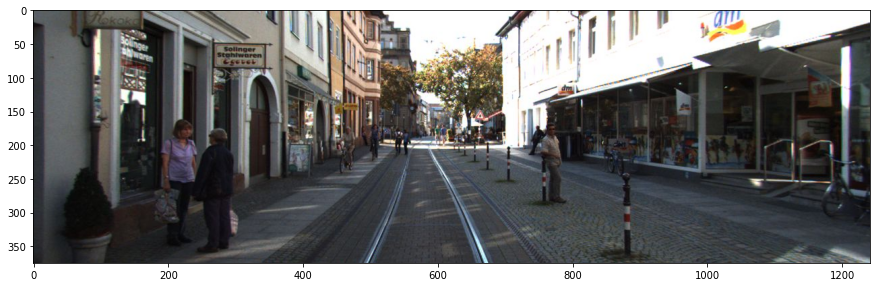

In [ ]:
# 简单查看数据集的图片
import mmcv
import matplotlib.pyplot as plt

img = mmcv.imread('kitti_tiny/training/image_2/000073.jpeg')
plt.figure(figsize=(15, 10))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

In [ ]:
# 查看单张图的标注信息
!cat kitti_tiny/training/label_2/000073.txt

Pedestrian 0.00 0 -2.62 237.23 173.70 312.33 365.33 1.58 0.66 0.53 -2.99 1.60 6.32 -3.05
Pedestrian 0.00 1 0.80 189.46 158.23 256.19 356.44 1.70 0.61 0.51 -3.62 1.58 6.54 0.31
Pedestrian 0.00 0 0.45 752.95 164.08 791.19 288.78 1.75 0.63 0.51 2.28 1.63 10.51 0.65
Cyclist 0.00 0 1.78 444.66 170.48 485.70 241.86 1.64 0.57 2.00 -3.55 1.60 17.61 1.58
Cyclist 0.00 0 1.65 494.34 168.08 517.01 223.73 1.80 0.60 1.85 -3.54 1.66 24.31 1.51
Pedestrian 0.00 0 -2.07 546.73 177.07 560.52 214.88 1.53 0.61 0.73 -2.41 1.71 29.83 -2.15
Pedestrian 0.00 0 -2.02 535.68 174.41 549.63 214.38 1.61 0.54 0.87 -2.86 1.68 29.55 -2.12
DontCare -1 -1 -10 596.02 166.69 615.85 203.19 -1 -1 -1 -1000 -1000 -1000 -10


根据KITTI数据集文档，标注的第一列指物体的类别，第五列到第八列指的是边界框的左上右下坐标，这些就是我们需要转换的信息。

#### 转换为中间数据集格式

中间数据集格式定义如下：

```python
[
    {
        'filename': 'a.jpg',
        'width': 1280,
        'height': 720,
        'ann': {
            'bboxes': <np.ndarray, float32> (n, 4),
            'labels': <np.ndarray, int64> (n, ),
            'bboxes_ignore': <np.ndarray, float32> (k, 4),
            'labels_ignore': <np.ndarray, int64> (k, ) (optional field)
        }
    },
    ...
]
```
我们需要根据上述中间类型来编写转换函数。

In [ ]:
import os.path as osp
import numpy as np
import mmcv

def convert_kitti_to_middle(ann_file, out_file, img_prefix):

    CLASSES = ('Car', 'Pedestrian', 'Cyclist')
    # 类别反查表
    cat2label = {k: i for i, k in enumerate(CLASSES)}
    # 图像列表
    image_list = mmcv.list_from_file(ann_file)

    # 所有图像和标注的信息存储在一个列表中
    data_infos = []
    # convert annotations to middle format
    for image_id in image_list:
        filename = f'{img_prefix}/{image_id}.jpeg'
        image = mmcv.imread(filename)
        height, width = image.shape[:2]

        # 单张图像的信息存储在字典中
        data_info = dict(filename=f'{image_id}.jpeg', width=width, height=height)

        # 读取标注信息，并处理
        label_prefix = img_prefix.replace('image_2', 'label_2')
        lines = mmcv.list_from_file(osp.join(label_prefix, f'{image_id}.txt'))

        content = [line.strip().split(' ') for line in lines]
        bbox_names = [x[0] for x in content]
        bboxes = [[float(info) for info in x[4:8]] for x in content]

        gt_bboxes = []
        gt_labels = []
        gt_bboxes_ignore = []
        gt_labels_ignore = []

        # filter 'DontCare'
        for bbox_name, bbox in zip(bbox_names, bboxes):
            if bbox_name in cat2label:
                gt_labels.append(cat2label[bbox_name])
                gt_bboxes.append(bbox)
            else:
                gt_labels_ignore.append(-1)
                gt_bboxes_ignore.append(bbox)

        # 将标注信息（坐标和标签）转换为nparray
        data_anno = dict(
            bboxes=np.array(gt_bboxes, dtype=np.float32).reshape(-1, 4),
            labels=np.array(gt_labels, dtype=np.long),
            bboxes_ignore=np.array(gt_bboxes_ignore,
                                    dtype=np.float32).reshape(-1, 4),
            labels_ignore=np.array(gt_labels_ignore, dtype=np.long))

        data_info.update(ann=data_anno)
        # 所有图像和标注的信息存储在一个列表中
        data_infos.append(data_info)
    mmcv.dump(data_infos, out_file)

convert_kitti_to_middle('kitti_tiny/train.txt', 'kitti_tiny/train_middle.pkl', 'kitti_tiny/training/image_2')
convert_kitti_to_middle('kitti_tiny/val.txt', 'kitti_tiny/val_middle.pkl', 'kitti_tiny/training/image_2')

#### 修改配置文件参数

In [ ]:
# 下载需要用到的faster rcnn模型
!mkdir checkpoints
!wget -c http://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_caffe_fpn_1x_coco/faster_rcnn_r50_caffe_fpn_1x_coco_bbox_mAP-0.378_20200504_180032-c5925ee5.pth \
      -O checkpoints/faster_rcnn_r50_caffe_fpn_1x_coco_bbox_mAP-0.378_20200504_180032-c5925ee5.pth

--2021-05-02 14:24:02--  http://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_caffe_fpn_1x_coco/faster_rcnn_r50_caffe_fpn_1x_coco_bbox_mAP-0.378_20200504_180032-c5925ee5.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.254.186.225
Connecting to download.openmmlab.com (download.openmmlab.com)|47.254.186.225|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 167290848 (160M) [application/octet-stream]
Saving to: ‘checkpoints/faster_rcnn_r50_caffe_fpn_1x_coco_bbox_mAP-0.378_20200504_180032-c5925ee5.pth’

checkpoints/faster_ 100%[===================>] 159.54M  2.68MB/s    in 75s     

2021-05-02 14:25:18 (2.13 MB/s) - ‘checkpoints/faster_rcnn_r50_caffe_fpn_1x_coco_bbox_mAP-0.378_20200504_180032-c5925ee5.pth’ saved [167290848/167290848]



In [ ]:
from mmcv import Config
from mmdet.apis import set_random_seed

# 获取基本配置文件参数
cfg = Config.fromfile('./configs/faster_rcnn/faster_rcnn_r50_caffe_fpn_mstrain_1x_coco.py')

# 修改数据集类型以及文件路径
cfg.dataset_type = 'CustomDataset'
cfg.data_root = 'kitti_tiny/'
cfg.classes = ('Car', 'Pedestrian', 'Cyclist')

cfg.data.test.type = 'CustomDataset'
cfg.data.test.data_root = 'kitti_tiny/'
cfg.data.test.ann_file = 'train_middle.pkl'
cfg.data.test.img_prefix = 'training/image_2'
cfg.data.test.classes = ('Car', 'Pedestrian', 'Cyclist')

cfg.data.train.type = 'CustomDataset'
cfg.data.train.data_root = 'kitti_tiny/'
cfg.data.train.ann_file = 'train_middle.pkl'
cfg.data.train.img_prefix = 'training/image_2'
cfg.data.train.classes = ('Car', 'Pedestrian', 'Cyclist')

cfg.data.val.type = 'CustomDataset'
cfg.data.val.data_root = 'kitti_tiny/'
cfg.data.val.ann_file = 'val_middle.pkl'
cfg.data.val.img_prefix = 'training/image_2'
cfg.data.val.classes = ('Car', 'Pedestrian', 'Cyclist')

# 修改bbox_head中的类别数
cfg.model.roi_head.bbox_head.num_classes = 3
# 使用预训练好的faster rcnn模型用于finetuning
cfg.load_from = 'checkpoints/faster_rcnn_r50_caffe_fpn_1x_coco_bbox_mAP-0.378_20200504_180032-c5925ee5.pth'
# 设置工作目录用于存放log和临时文件
cfg.work_dir = './work_dir_custom'

# 原本的学习率是在8卡基础上训练设置的，现在单卡需要除以8
cfg.optimizer.lr = 0.02 / 8
cfg.lr_config.warmup = None
cfg.log_config.interval = 10

# 由于是自定义数据集，需要修改评价方法
cfg.evaluation.metric = 'mAP'
# 设置evaluation间隔减少运行时间
cfg.evaluation.interval = 12
# 设置存档点间隔减少存储空间的消耗
cfg.checkpoint_config.interval = 12

# 固定随机种子使得结果可复现
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# 打印所有的配置参数
print(f'Config:\n{cfg.pretty_text}')

mmcv.mkdir_or_exist(F'{cfg.work_dir}')
cfg.dump(F'{cfg.work_dir}/customformat.py')

Config:
model = dict(
    type='FasterRCNN',
    pretrained='open-mmlab://detectron2/resnet50_caffe',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=False),
        norm_eval=True,
        style='caffe'),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_weight=1.0),
        los

#### 训练新模型

这里需要根据配置文件构建数据集，检测模型并完成训练。

In [ ]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector

# 构建数据集
datasets = [build_dataset(cfg.data.train)]

# 构建检测模型
model = build_detector(cfg.model)
# 添加类别文字属性提高可视化效果
model.CLASSES = datasets[0].CLASSES

# 创建工作目录并训练模型
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
cfg.device = 'cuda'
train_detector(model, datasets, cfg, distributed=False, validate=True)

/content/mmdetection/mmdet/datasets/custom.py:156: UserWarning: CustomDataset does not support filtering empty gt images.
  'CustomDataset does not support filtering empty gt images.')
/content/mmdetection/mmdet/models/backbones/resnet.py:400: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
2021-05-02 14:34:46,468 - mmdet - INFO - load checkpoint from checkpoints/faster_rcnn_r50_caffe_fpn_1x_coco_bbox_mAP-0.378_20200504_180032-c5925ee5.pth
2021-05-02 14:34:46,470 - mmdet - INFO - Use load_from_local loader
2021-05-02 14:34:46,617 - mmdet - WARNING - The model and loaded state dict do not match exactly

size mismatch for roi_head.bbox_head.fc_cls.weight: copying a param with shape torch.Size([81, 1024]) from checkpoint, the shape in current model is torch.Size([4, 1024]).
size mismatch for roi_head.bbox_head.fc_cls.bias: copying a param with shape torch.Size([81]) from checkpoin

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 25/25, 3.9 task/s, elapsed: 6s, ETA:     0s
---------------iou_thr: 0.5---------------


2021-05-02 14:39:49,715 - mmdet - INFO - 
+------------+-----+------+--------+-------+
| class      | gts | dets | recall | ap    |
+------------+-----+------+--------+-------+
| Car        | 62  | 155  | 0.968  | 0.860 |
| Pedestrian | 13  | 64   | 0.846  | 0.790 |
| Cyclist    | 7   | 69   | 0.571  | 0.079 |
+------------+-----+------+--------+-------+
| mAP        |     |      |        | 0.576 |
+------------+-----+------+--------+-------+
2021-05-02 14:39:49,720 - mmdet - INFO - Epoch(val) [12][25]	AP50: 0.5760, mAP: 0.5763


#### 评价模型

训练完模型后，需要对模型进行评价分析，这里可以用mmdet提供的test.py来直接运行。更多评价方法可以查看[这里](https://mmdetection.readthedocs.io/en/latest/1_exist_data_model.html)

In [ ]:
!python tools/test.py work_dir_custom/customformat.py work_dir_custom/latest.pth --eval mAP

Use load_from_local loader
[>>] 50/50, 4.3 task/s, elapsed: 12s, ETA:     0s
---------------iou_thr: 0.5---------------

+------------+-----+------+--------+-------+
| class      | gts | dets | recall | ap    |
+------------+-----+------+--------+-------+
| Car        | 147 | 349  | 0.993  | 0.990 |
| Pedestrian | 23  | 129  | 0.957  | 0.887 |
| Cyclist    | 7   | 154  | 1.000  | 0.982 |
+------------+-----+------+--------+-------+
| mAP        |     |      |        | 0.953 |
+------------+-----+------+--------+-------+
OrderedDict([('AP50', 0.953), ('mAP', 0.953007698059082)])


#### 测试训练好的检测模型

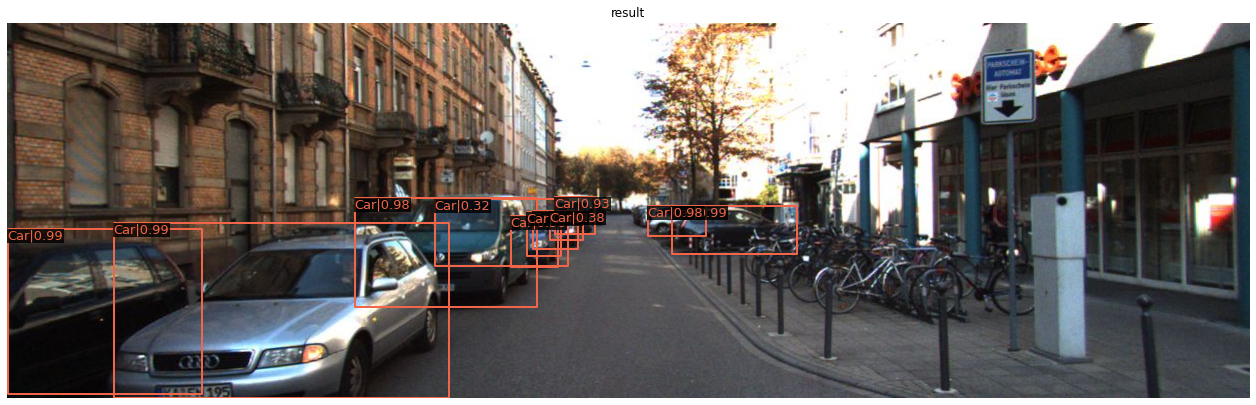

In [ ]:
from mmdet.apis import inference_detector, show_result_pyplot

img = mmcv.imread('kitti_tiny/training/image_2/000068.jpeg')

model.cfg = cfg
result = inference_detector(model, img)
show_result_pyplot(model, img, result)

### 方法三：直接实现新数据集的支持

方法一、二是离线方法，需要将数据转换好存到磁盘上，再进行训练。
MMDetection还支持一种在线的方法，可以直接从原始数据集文件读取数据，在线完成转换（至MMDetection的中间格式），并发送给模型用于训练，过程中需不需要存储额外数据到硬盘上。


这里我们将同样基于数据集[KITTI](http://www.cvlibs.net/datasets/kitti/eval_object.php?obj_benchmark=3d)，通过方法三完成训练。


#### 支持新数据集

我们在方法二中已经实现了转换方法，这里可以不用生成新的文件，直接支持新的数据集。

In [ ]:
import copy
import os.path as osp

import mmcv
import numpy as np

from mmdet.datasets.builder import DATASETS
from mmdet.datasets.custom import CustomDataset

# 注册表的装饰器，这样builder根据配置文件构建时就可以识别KittiTinyDataset数据集类型
# 继承CustomDataset并重载load_annotations函数
@DATASETS.register_module()
class KittiTinyDataset(CustomDataset):

    CLASSES = ('Car', 'Pedestrian', 'Cyclist')

    def load_annotations(self, ann_file):
        cat2label = {k: i for i, k in enumerate(self.CLASSES)}
        # load image list from file
        image_list = mmcv.list_from_file(self.ann_file)
    
        data_infos = []
        # convert annotations to middle format
        for image_id in image_list:
            filename = f'{self.img_prefix}/{image_id}.jpeg'
            image = mmcv.imread(filename)
            height, width = image.shape[:2]
    
            data_info = dict(filename=f'{image_id}.jpeg', width=width, height=height)
    
            # load annotations
            label_prefix = self.img_prefix.replace('image_2', 'label_2')
            lines = mmcv.list_from_file(osp.join(label_prefix, f'{image_id}.txt'))
    
            content = [line.strip().split(' ') for line in lines]
            bbox_names = [x[0] for x in content]
            bboxes = [[float(info) for info in x[4:8]] for x in content]
    
            gt_bboxes = []
            gt_labels = []
            gt_bboxes_ignore = []
            gt_labels_ignore = []
    
            # filter 'DontCare'
            for bbox_name, bbox in zip(bbox_names, bboxes):
                if bbox_name in cat2label:
                    gt_labels.append(cat2label[bbox_name])
                    gt_bboxes.append(bbox)
                else:
                    gt_labels_ignore.append(-1)
                    gt_bboxes_ignore.append(bbox)

            data_anno = dict(
                bboxes=np.array(gt_bboxes, dtype=np.float32).reshape(-1, 4),
                labels=np.array(gt_labels, dtype=np.long),
                bboxes_ignore=np.array(gt_bboxes_ignore,
                                       dtype=np.float32).reshape(-1, 4),
                labels_ignore=np.array(gt_labels_ignore, dtype=np.long))

            data_info.update(ann=data_anno)
            data_infos.append(data_info)

        return data_infos

#### 修改配置文件参数

In [ ]:
from mmcv import Config
from mmdet.apis import set_random_seed

# 获取基本配置文件参数
cfg = Config.fromfile('./configs/faster_rcnn/faster_rcnn_r50_caffe_fpn_mstrain_1x_coco.py')

# 修改数据集类型以及文件路径
cfg.dataset_type = 'KittiTinyDataset'
cfg.data_root = 'kitti_tiny/'

cfg.data.test.type = 'KittiTinyDataset'
cfg.data.test.data_root = 'kitti_tiny/'
cfg.data.test.ann_file = 'train.txt'
cfg.data.test.img_prefix = 'training/image_2'

cfg.data.train.type = 'KittiTinyDataset'
cfg.data.train.data_root = 'kitti_tiny/'
cfg.data.train.ann_file = 'train.txt'
cfg.data.train.img_prefix = 'training/image_2'

cfg.data.val.type = 'KittiTinyDataset'
cfg.data.val.data_root = 'kitti_tiny/'
cfg.data.val.ann_file = 'val.txt'
cfg.data.val.img_prefix = 'training/image_2'

# 修改bbox_head中的类别数
cfg.model.roi_head.bbox_head.num_classes = 3
# 使用预训练好的faster rcnn模型用于finetuning
cfg.load_from = 'checkpoints/faster_rcnn_r50_caffe_fpn_1x_coco_bbox_mAP-0.378_20200504_180032-c5925ee5.pth'
# 设置工作目录用于存放log和临时文件
cfg.work_dir = './tutorial_exps'

# 原本的学习率是在8卡基础上训练设置的，现在单卡需要除以8
cfg.optimizer.lr = 0.02 / 8
cfg.lr_config.warmup = None
cfg.log_config.interval = 10

# 由于是自定义数据集，需要修改评价方法
cfg.evaluation.metric = 'mAP'
# 设置evaluation间隔减少运行时间
cfg.evaluation.interval = 12
# 设置存档点间隔减少存储空间的消耗
cfg.checkpoint_config.interval = 12

# 固定随机种子使得结果可复现
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# 打印所有的配置参数
print(f'Config:\n{cfg.pretty_text}')

Config:
model = dict(
    type='FasterRCNN',
    pretrained='open-mmlab://detectron2/resnet50_caffe',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=False),
        norm_eval=True,
        style='caffe'),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_weight=1.0),
        los

#### 训练新模型

这里需要根据配置文件构建数据集，检测模型并完成训练。

In [ ]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector

# 构建数据集
datasets = [build_dataset(cfg.data.train)]

# 构建检测模型
model = build_detector(cfg.model)
# 添加类别文字属性提高可视化效果
model.CLASSES = datasets[0].CLASSES

# 创建工作目录并训练模型
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)

/content/mmdetection/mmdet/datasets/custom.py:156: UserWarning: CustomDataset does not support filtering empty gt images.
  'CustomDataset does not support filtering empty gt images.')
/content/mmdetection/mmdet/models/backbones/resnet.py:400: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
2021-05-02 14:48:45,271 - mmdet - INFO - load checkpoint from checkpoints/faster_rcnn_r50_caffe_fpn_1x_coco_bbox_mAP-0.378_20200504_180032-c5925ee5.pth
2021-05-02 14:48:45,273 - mmdet - INFO - Use load_from_local loader
2021-05-02 14:48:45,417 - mmdet - WARNING - The model and loaded state dict do not match exactly

size mismatch for roi_head.bbox_head.fc_cls.weight: copying a param with shape torch.Size([81, 1024]) from checkpoint, the shape in current model is torch.Size([4, 1024]).
size mismatch for roi_head.bbox_head.fc_cls.bias: copying a param with shape torch.Size([81]) from checkpoin

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 25/25, 4.1 task/s, elapsed: 6s, ETA:     0s
---------------iou_thr: 0.5---------------


2021-05-02 14:53:49,541 - mmdet - INFO - 
+------------+-----+------+--------+-------+
| class      | gts | dets | recall | ap    |
+------------+-----+------+--------+-------+
| Car        | 62  | 171  | 0.935  | 0.836 |
| Pedestrian | 13  | 74   | 0.846  | 0.782 |
| Cyclist    | 7   | 76   | 0.571  | 0.068 |
+------------+-----+------+--------+-------+
| mAP        |     |      |        | 0.562 |
+------------+-----+------+--------+-------+
2021-05-02 14:53:49,546 - mmdet - INFO - Epoch(val) [12][25]	AP50: 0.5620, mAP: 0.5621


#### 测试训练好的检测模型

In [ ]:
from mmdet.apis import inference_detector, show_result_pyplot

img = mmcv.imread('kitti_tiny/training/image_2/000068.jpeg')

model.cfg = cfg
result = inference_detector(model, img)
show_result_pyplot(model, img, result)